# Deliverable 3 Notebook 1

## How to detect and attribute changes on Land Surface Temperature (LST) produced by land cover changes.

For this excersice we will use the EarthSystemDataCube (ESDC). Unfortunately the Earth SystemDataCube does not have land cover maps necessaries for the analysis. Then, we will use MODIS Land Cover  MCD12Q1 product.

activating local environment


In [1]:
using Pkg
# the path where you have the Manifest.toml and Project.toml 
Pkg.activate("/Net/Groups/BGI/people/dpabon/nfdi4earth_oemc")
# run the line below only once to install all the necessary packages (This will take a while!!)
#Pkg.instantiate()

  Activating project at `/Net/Groups/BGI/people/dpabon/nfdi4earth_oemc`


Necessary packages:


In [2]:
using YAXArrays
using DataFrames
using XLSX
using CSV
using Zarr
using NetCDF
using CairoMakie
using GeoMakie
using Statistics
using LinearAlgebra
using NamedArrays
using Combinatorics
using GLM
using BenchmarkTools
using ProgressMeter
using NetCDF
using Zarr
using Glob
using YAXArrayBase
using Dates
using Rasters
using Interpolations
using DiskArrayTools
using ColorSchemes
using Skipper
using YAXArraysToolbox

In [53]:
# the folder where the YAXArrays packages will allocate temporal files
YAXArrays.YAXdir("/Net/Groups/BGI/scratch/dpabon/YAXA_tmp")

#activating CairoMakie for plotting
CairoMakie.activate!()

## Data (ready to use)


In [4]:
# Land surface temperature product
lst_monthly_high = open_dataset("/Net/Groups/BGI/scratch/dpabon/lst_monthly_high.zarr")
lst_monthly_high = Cube(lst_monthly_high)

# Land cover classes product
lcc_final_cube = open_dataset("/Net/Groups/BGI/scratch/dpabon/MCD12Q1_006_IGBP_fraction.2002_2011_8d-0.083deg.zarr")
lcc_final_cube = Cube(lcc_final_cube)

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
classes             Axis with 17 elements: Evergreen_Needleleaf_Forests Evergreen_Broadleaf_Forests .. Barren Water_Bodies 
lon                 Axis with 4320 Elements from -179.95833333333331 to 179.95833333333331
lat                 Axis with 2160 Elements from 89.95833333333334 to -89.95833333333333
name: layer
Total size: 68.55 GB


## Data preparation (Steps)

Loading the earth system data cube:


In [6]:
#| eval: false
earth_dataset = open_dataset("/Net/Groups/BGI/work_1/scratch/s3/esdl-esdc-v2.1.1/esdc-8d-0.083deg-184x270x270-2.1.1.zarr/")

YAXArray Dataset
Dimensions: 
   lat                 Axis with 2160 Elements from 89.95833333333334 to -89.95833333333333
   lon                 Axis with 4320 Elements from -179.95833333333331 to 179.95833333333331
   time                Axis with 1840 Elements from 1979-01-05T00:00:00 to 2018-12-31T00:00:00
Variables: xco2 leaf_area_index sensible_heat flt_c totcol_msr stemp free_lrt_c lrt_c potential_evaporation evaporation root_moisture radiation_era5 land_surface_temperature black_sky_albedo_avhrr precipitation free_flt_c open_water_evaporation lrt_p srex_mask latent_energy max_air_temperature_2m xch4 cth psurf aerosol_optical_thickness_550 aerosol_optical_thickness_870 ctt air_temperature_2m msr_flt free_msr_lrt evaporative_stress precipitation_era5 aerosol_optical_thickness_670 snow_water_equivalent black_sky_albedo terrestrial_ecosystem_respiration analysed_sst mask white_sky_albedo aerosol_optical_thickness_1600 totcol_assim fractional_snow_cover chlor_a gross_primary_producti

In [7]:
# another way to load the esdc for external people will be using

#=
earth_dataset = esdd()
=#

### Land Surface temperature product

Checking the properties of the land surface temperature product:


In [8]:
earth_dataset.land_surface_temperature.properties

Dict{String, Any} with 12 entries:
  "long_name"                => "Land Surface Temperature"
  "time_coverage_end"        => "2011-12-31"
  "time_coverage_resolution" => "P8D"
  "time_coverage_start"      => "2002-05-21"
  "name"                     => "land_surface_temperature"
  "esa_cci_path"             => "NaN"
  "orig_version"             => "NaN"
  "ID"                       => 69
  "_FillValue"               => NaN
  "url"                      => "http://data.globtemperature.info/"
  "units"                    => "K"
  "project_name"             => "GlobTemperature"

In [9]:
#lst = earth_dataset.land_surface_temperature[time = (Date("2002-05-21"),Date("2011-12-31"))]

#### Estimating the median per month for the LST product

For this we will need the ```median_by_index``` and ```dates_builders``` function

Now we will create the index to map the values using mapcube later


In [10]:
#=
time_to_index = getAxis("time", lst)

time_index = yearmonth.(time_to_index)

new_dates = unique(time_index)

index_in_cube = [findall(==(i), time_index) for i in new_dates]
=#

In [11]:
#new_dates

To run mapcube we need to first define our input and output dimenssions. In this case our input dimension is time and the output dimension is time *but* with the ```new_dates```. ```dates_builder``` takes a list of tuples and creates a new Dates array


In [12]:
#=
Indims = InDims("Time")

outdims = OutDims(RangeAxis("time", dates_builder(new_dates)))
=#

Now we can use mapCube to estimate the median per month.


In [13]:
#lst_monthly_high = mapCube(median_by_index, lst, indims = Indims, outdims = outdims; index_list = index_in_cube, showprog = true)

Let's do a quick inspection of the result using CairoMakie and GeoMakie


In [14]:
#=
lon = getAxis("lon", lst_monthly_high).values
lat = getAxis("lat", lst_monthly_high).values
fig = Figure(resolution = (1100,500), fontsize = 24)
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (-180, 180),
    latlims = (-90, 90),
    title = string(lst_monthly_high.time[1])
)
map1 = CairoMakie.heatmap!(ga, lon, lat, lst_monthly_high.data[1,:,:], colormap = Reverse(:batlow))
cbar1 = Colorbar(fig[1,2], map1, label= "LST (K)", ticklabelsize=18, labelpadding=5, width=10)
fig
#

LoadError: syntax: incomplete: unterminated multi-line comment #= ... =#

### MODIS Land cover product (MCD12Q1)

We already prepared a zarr cube with the data necessary for the analysis. Neverthelesss, Below you can find the post-processing necessary for land cover map, in other words the necessary steps to match time dimension with the LST product.


In [15]:
#| eval: false
# Loading ready to use land cover product
#lcc_final_cube = open_dataset("/Net/Groups/BGI/scratch/dpabon/lcc_final_cube_2002_2011_8d-0.083deg.zarr")
#lcc_final_cube = Cube(lcc_final_cube)

Let's do a quick inspection of the cube


In [16]:
#| eval: false
#=
lon = getAxis("lon", lcc_final_cube).values
lat = getAxis("lat", lcc_final_cube).values
time_index = 100
class_index = 1


fig = Figure(resolution = (1100,500), fontsize = 24)

ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (-180, 180),
    latlims = (-90, 90),
    title = string(lcc_final_cube.time[time_index]) * "\n" * string(lcc_final_cube.classes[class_index])
)
map1 = CairoMakie.heatmap!(ga, lon, lat, lcc_final_cube[time_index,class_index,:,:], colormap = Reverse(:batlow))
cbar1 = Colorbar(fig[1,2], map1, label= "Land cover percentage", ticklabelsize=18, labelpadding=5, width=10)
fig
=#

---------------

#### Processing the MCD12Q1 product 
You don't need to run this section!! Neverthless if you want to understand how the MCD12Q1 was wrapped in zarr please go ahead.

For details of the MCD12Q1 please see: https://lpdaac.usgs.gov/products/mcd12q1v006/

Land cover maps are produced anually then we need to extend the data to match the spatial resolution of the LST product. To do this we will use the ```filling_time``` function. In this case we have a series of necdfs files one file per year


In [17]:
#| eval: false
# lcc_files = glob("*.nc","/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d083_annual/MCD12Q1/V006/Data/")

first we need to check which years are on the LST product and then filter the files names

In [18]:
#| eval: false
#=
years_lst = [new_dates[i][1] for i in eachindex(new_dates)]

years_lst_unique = unique(years_lst)

lcc_files = lcc_files[reduce(vcat,[findall(x -> occursin(string(years_lst_unique[i]), x), lcc_files) for i in eachindex(years_lst_unique)])]
=#

Let's index all the files in a single vector:


In [19]:
#| eval: false
#lcc_cubes = YAXArray[]

Then we use the ```filling_time``` time and a loop to build the time series with the same dates as in the LST product

In [20]:
#| eval: false
#=
@showprogress for i in eachindex(lcc_files)
    
    
    # open each file w
    test_dataset = open_dataset(lcc_files[i])
    

    # filter out the dates corresponding to the year i
    single_year_dates = findall(==(years_lst_unique[i]), years_lst)
    
    # define input and output axis of the cube
    indims = InDims("classes")
    # the output axis have the time and the land cover classes
    outdims = OutDims(RangeAxis("time", dates_builder(new_dates)[single_year_dates]), CategoricalAxis("classes", ["Evergreen_Needleleaf_Forests", "Evergreen_Broadleaf_Forests", "Deciduous_Needleleaf_Forests", "Deciduous_Broadleaf_Forests", "Mixed_Forests", "Closed_Shrublands", "Open_Shrublands", "Woody_Savannas", "Savannas", "Grasslands", "Permanent_Wetlands", "Croplands", "Urban_and_Built-up_Lands", "Cropland_Natural_Vegetation_Mosaics", "Permanent_Snow_and_Ice", "Barren", "Water_Bodies"]))
    
    # adding the resulting cube to the empty array
    push!(lcc_cubes, mapCube(filling_time, test_dataset.MCD12Q1_006_IGBP_fraction, indims = indims, outdims = outdims, showprog = true)) 
end
=#

In [21]:
#| eval: false
#lcc_cubes

Now we can merge the cubes in a single one for this we need to use the ```DiskArrayTools``` package


In [22]:
#| eval: false

#=
# extracting the data for each cube
arraylist = [c.data for c in lcc_cubes]
# concatenating the data
diskarray_concat = ConcatDiskArray(arraylist)
# creating a vector with the time axis
alltimes = [c.time.values for c in lcc_cubes]
timeax = RangeAxis("time",reduce(vcat,alltimes))
# creating a new array with the data + the properties of one of the cubes
lcc_final_cube = YAXArray([[timeax];lcc_cubes[1].axes[2:end]],diskarray_concat,lcc_cubes[1].properties)

=#

In [23]:
#| eval: false

#lcc_final_cube

each one of the cubes have different names for latitude and longitude. To run space4time we need consistency in the names, then we will use the ```renameaxis!()``` function to change the names.


In [24]:
#| eval: false
#=
renameaxis!(lcc_final_cube, "longitude" => getAxis("lon", lst_monthly_high))
renameaxis!(lcc_final_cube, "latitude" => getAxis("lat", lst_monthly_high))
=#

In [25]:
#| eval: false
#lcc_final_cube_chunked = setchunks(lcc_final_cube, (time = 116, classes = 17, lon = 432, lat = 135))

In [26]:
# saving lcc_final_cube and LST cube to save time and ram memory
# savecube(lcc_final_cube_chunked, "/Net/Groups/BGI/scratch/dpabon/lcc_final_cube_2002_2011_8d-0.083deg.zarr", overwrite = true)

---

## Africa section


In [5]:
lcc_africa = lcc_final_cube[lon =(-26, 61), lat = (38, -37)]
lst_africa = lst_monthly_high[lon =(-26, 61), lat = (38, -37)]

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
name: layer
Total size: 415.78 MB


First we'll plot the LST product for a single time-step

┌ Warning: Could not find font regular, using TeX Gyre Heros Makie
└ @ Makie /Net/Groups/BGI/people/dpabon/bin/julia_packages/packages/Makie/gAmAB/src/conversions.jl:940


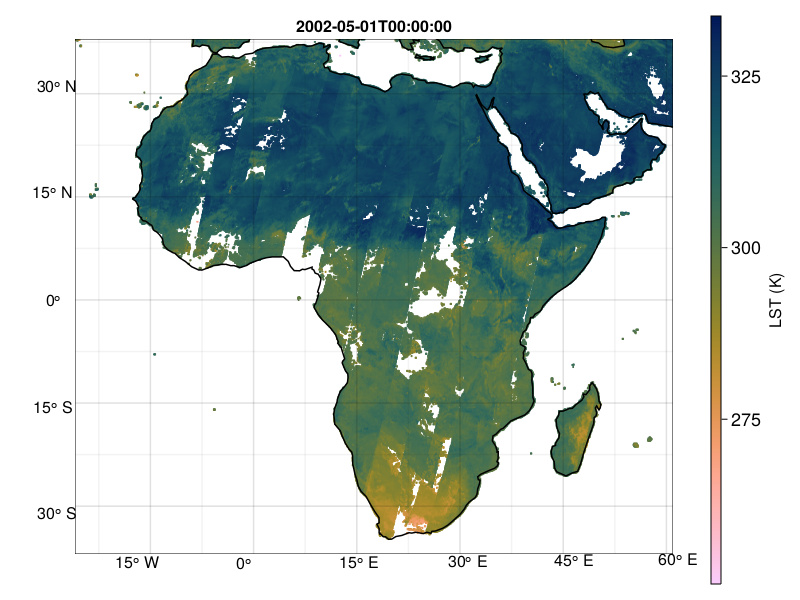

In [6]:
lon = getAxis("lon", lst_africa).values
lat = getAxis("lat", lst_africa).values

time_to_plot = 1

fig = Figure()
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lst_africa.lon), maximum(lst_africa.lon)),
    latlims = (minimum(lst_africa.lat), maximum(lst_africa.lat)),
    title = string(lst_africa.time[time_to_plot])
)
map1 = CairoMakie.heatmap!(ga, lon, lat, lst_africa.data[time_to_plot,:,:], colormap = Reverse(:batlow))
cbar1 = Colorbar(fig[1,2], map1, label= "LST (K)", ticklabelsize=18, labelpadding=5, width=10)
fig

Now we can plot the distribution of the IGBP classes

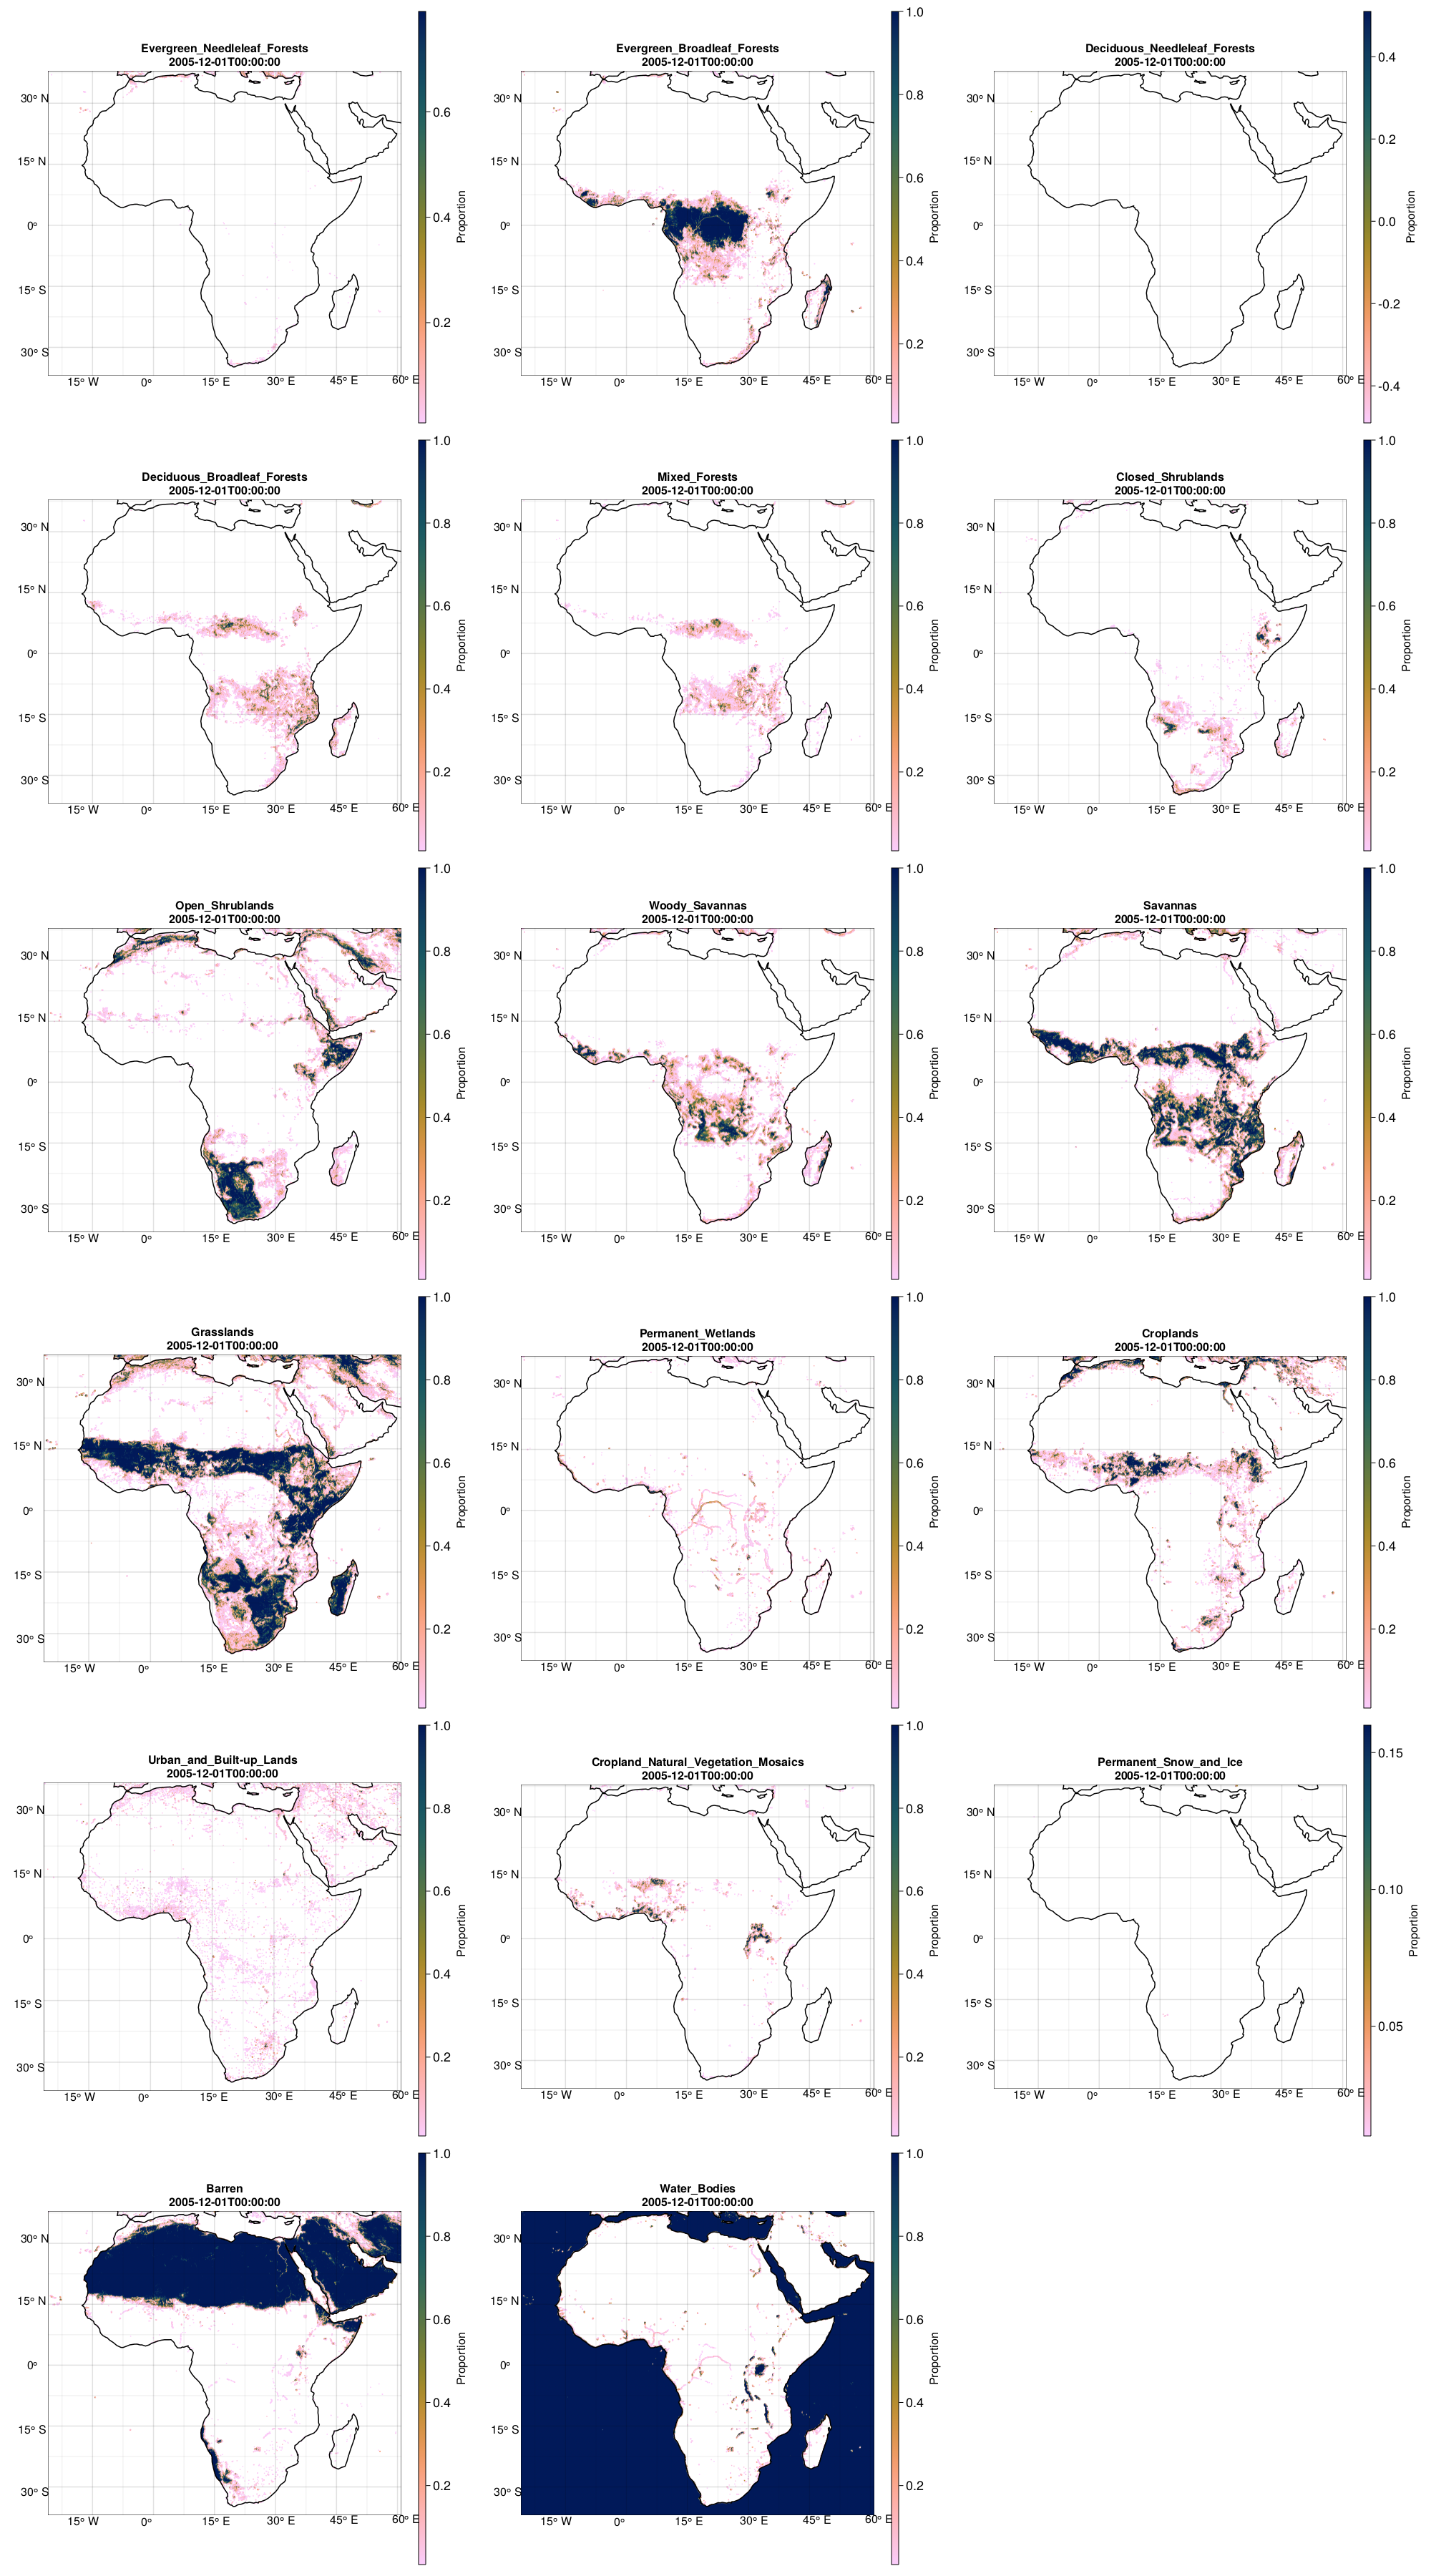

In [7]:
time_to_plot = 44

lon = getAxis("lon", lcc_africa).values
lat = getAxis("lat", lcc_africa).values
lcc_classes = getAxis("classes", lcc_africa).values
time_cube = getAxis("time", lcc_africa).values
discrete_classes = getAxis("classes", lcc_africa).values
fig = Figure(resolution=(2000, 3600))
init_row = 1
init_col = 1
for i in 1:6
    for j in 1:3
    #println(i)
    ga = GeoAxis(
    fig[i, init_col],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title =  lcc_classes[init_row] * string("\n", time_cube[time_to_plot])
)
    map1 = CairoMakie.heatmap!(ga, lon, lat, lcc_africa.data[time_to_plot,init_row,:,:], colormap = Reverse(:batlow))
        init_row += 1
        init_col += 1
    cbar1 = Colorbar(fig[i,init_col], map1, label= "Proportion", ticklabelsize=18, labelpadding=5, width=10)
        init_col += 1
        if init_row > length(lcc_classes)
            break
end
    end
    init_col = 1
end
fig

----

## Runing space for time technique

Now that the LST product and the vegetation classes have the same temporal-spatial resolution, we need to define which transitions we would like to analyze.

The full list of the classes is:

```
lcc_classes = ["Evergreen_Needleleaf_Forests", 
    "Evergreen_Broadleaf_Forests", 
    "Deciduous_Needleleaf_Forests", 
    "Deciduous_Broadleaf_Forests", 
    "Mixed_Forests", 
    "Closed_Shrublands", 
    "Open_Shrublands", 
    "Woody_Savannas", 
    "Savannas", 
    "Grasslands", 
    "Permanent_Wetlands", 
    "Croplands", 
    "Cropland_Natural_Vegetation_Mosaics", 
    "Permanent_Snow_and_Ice", 
    "Barren", 
    Urban_and_Built-up_Lands,
    Water_Bodies]
```
**!!** It is important to remember that all the pontential transitions will be evaluate by pairs. Then we can use combination formula to estimate the number of combinations  $ C(n,r) = \dfrac{n!}{r!(n-r)!} $ where $ n $ is the number of elements and $r$ the number of elements per sample.

Then for 17 classes we have 136 transitions. In other words, The number of transitions increases the size of the result exponentially **!!**


In [8]:
lcc_classes = ["Evergreen_Needleleaf_Forests", 
    "Evergreen_Broadleaf_Forests", 
    "Deciduous_Needleleaf_Forests", 
    "Deciduous_Broadleaf_Forests", 
    "Mixed_Forests", 
    "Closed_Shrublands", 
    "Open_Shrublands", 
    "Woody_Savannas", 
    "Savannas", 
    "Grasslands", 
    "Permanent_Wetlands", 
    "Croplands", 
    "Cropland_Natural_Vegetation_Mosaics", 
    "Permanent_Snow_and_Ice", 
    "Barren", 
    "Urban_and_Built-up_Lands",
    "Water_Bodies"]

17-element Vector{String}:
 "Evergreen_Needleleaf_Forests"
 "Evergreen_Broadleaf_Forests"
 "Deciduous_Needleleaf_Forests"
 "Deciduous_Broadleaf_Forests"
 "Mixed_Forests"
 "Closed_Shrublands"
 "Open_Shrublands"
 "Woody_Savannas"
 "Savannas"
 "Grasslands"
 "Permanent_Wetlands"
 "Croplands"
 "Cropland_Natural_Vegetation_Mosaics"
 "Permanent_Snow_and_Ice"
 "Barren"
 "Urban_and_Built-up_Lands"
 "Water_Bodies"

## Running space for time for Africa

Running the analysis at continental scale takes a long time for this reason we will use a ready to use product.


In [9]:
# Running the space4time analysis:
#results_space4time = space4time_proc(lst_africa, lcc_africa, time_axis_name = "time", lon_axis_name = "lon", lat_axis_name = "lat", classes_var_name = "classes", winsize = 5, minDiffPxlspercentage = 5, classes_vec = lcc_classes,  max_value = 1, minpxl = 25, showprog = true)

In [10]:
# Setting chunks

#=
to_save_metrics_for_classes = setchunks(results_space4time.metrics_for_classes, (time = 58, classes = 1, Values_of_Z_for_pure_classes = 2, lon = 522, lat = 450))

to_save_metrics_for_transitions = setchunks(results_space4time.metrics_for_transitions, (time = 58, transitions = 1, Differences = 1, lon = 522, lat = 450))

to_save_summary_stats = setchunks(results_space4time.SummaryStats, (time = 58, summary_stat = 1, lon = 522, lat = 450))
=#


In [11]:
# Saving the results on zarr cubes
#=
#savecube(to_save_metrics_for_classes, "/Net/Groups/BGI/scratch/dpabon/results_space4time_small_latin_metrics_classes_slurm.zarr", overwrite = true)

savecube(to_save_metrics_for_transitions, "/Net/Groups/BGI/scratch/dpabon/results_space4time_small_latin_metrics_transitions_slurm.zarr", overwrite = true)

#savecube(to_save_summary_stats, "/Net/Groups/BGI/scratch/dpabon/results_space4time_small_latin_summary_stats_slurm.zarr", overwrite = true)
=#

In [12]:
#open the results
product_stats = open_dataset("/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_summary_stats_slurm.zarr/")
product_stats = Cube(product_stats)
product_classes = open_dataset("/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_metrics_classes_slurm.zarr/")
product_classes = Cube(product_classes)
product_transitions = open_dataset("/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_metrics_transitions_slurm.zarr/")
product_transitions = Cube(product_transitions)
results_space4time_africa = Dataset(;SummaryStats = product_stats, metrics_for_classes = product_classes, metrics_for_transitions = product_transitions)

YAXArray Dataset
Dimensions: 
   classes             Axis with 17 elements: Evergreen_Needleleaf_Forests Evergreen_Broadleaf_Forests .. Urban_and_Built-up_Lands Water_Bodies 
   transitions         Axis with 136 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Barren to Water_Bodies Urban_and_Built-up_Lands to Water_Bodies 
   summary_stat        Axis with 3 elements: rsquared cumulative_variance predicted 
   Differences         Axis with 3 elements: delta delta_error coocurence 
   lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
   Values_of_Z_for_pure_classesAxis with 2 elements: estimated estimated_error 
   lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
   time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
Variables: SummaryStats metrics_for_classes metrics_for_transitions 

In this case, the ```results_space4time_africa``` Dataset is the result of the ```space4time_proc``` function.

## Post-processing results for the African continent

The ```space4time_proc``` function produced three cubes in a single dataset. ```SummaryStats```, ```metrics_for_classes```, ```metrics_for_transitions```. we can have a look to each one of the objects. It is important to remember that we're running the analysis using a moving window.

```SummaryStats```: 
- rsquare: XXXX
- cumulative_variance: XXXX
- predicted: XXXX

```metrics_for_classes```:
- Values of Z for pure classes:
    - estimated : XXXX
    - estimated_error: XXXX 

```metrics_for_transitions```
 - transitions
 - Differences
     - delta: XXXX
     - delta_error: XXXX
     - coocurence: XXXX


In [13]:
results_space4time_africa.SummaryStats

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
summary_stat        Axis with 3 elements: rsquared cumulative_variance predicted 
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
name: layer
Total size: 1.22 GB


In [14]:
results_space4time_africa.metrics_for_classes

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
classes             Axis with 17 elements: Evergreen_Needleleaf_Forests Evergreen_Broadleaf_Forests .. Urban_and_Built-up_Lands Water_Bodies 
Values_of_Z_for_pure_classesAxis with 2 elements: estimated estimated_error 
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
name: layer
Total size: 13.81 GB


In [15]:
results_space4time_africa.metrics_for_transitions

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
transitions         Axis with 136 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Barren to Water_Bodies Urban_and_Built-up_Lands to Water_Bodies 
Differences         Axis with 3 elements: delta delta_error coocurence 
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
name: layer
Total size: 165.66 GB


now we will analyze the results. First we'll print all the transitions


In [16]:
transitions_names = getAxis("transitions", results_space4time_africa.metrics_for_transitions).values

136-element Vector{String}:
 "Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests"
 "Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests"
 "Evergreen_Needleleaf_Forests to Deciduous_Broadleaf_Forests"
 "Evergreen_Needleleaf_Forests to Mixed_Forests"
 "Evergreen_Needleleaf_Forests to Closed_Shrublands"
 "Evergreen_Needleleaf_Forests to Open_Shrublands"
 "Evergreen_Needleleaf_Forests to Woody_Savannas"
 "Evergreen_Needleleaf_Forests to Savannas"
 "Evergreen_Needleleaf_Forests to Grasslands"
 "Evergreen_Needleleaf_Forests to Permanent_Wetlands"
 "Evergreen_Needleleaf_Forests to Croplands"
 "Evergreen_Needleleaf_Forests to Cropland_Natural_Vegetation_Mosaics"
 "Evergreen_Needleleaf_Forests to Permanent_Snow_and_Ice"
 ⋮
 "Croplands to Urban_and_Built-up_Lands"
 "Croplands to Water_Bodies"
 "Cropland_Natural_Vegetation_Mosaics to Permanent_Snow_and_Ice"
 "Cropland_Natural_Vegetation_Mosaics to Barren"
 "Cropland_Natural_Vegetation_Mosaics to Urban_and_Built-up_Lands"
 "Cropl

### Filtering data using $R^{2}$, and co-occurrence

We will set the results to NaN when $R^{2} < 0.2$ and co-occurrence $<0.5$ for this we will use the ```masking_proc``` function.

In [17]:
#=
masking_without_delta = masking_proc(results_space4time_africa.metrics_for_transitions; 
cube_rsquared = results_space4time_africa.SummaryStats[summary_stat = "rsquared"], rsquared_thr = 0.2, 
cube_co_occurrence = results_space4time_africa.metrics_for_transitions[Differences = "coocurence"], co_occurence_thr = 0.5, 
cube_delta = nothing, time_dim = "time", showprog = true)

masking_results_chuncked = setchunks(masking_without_delta, (time = 58, transitions = 1, Differences = 1, lon = 522, lat = 450))

savecube(masking_results_chuncked, "/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_metrics_transitions_slurm_filtered_no_delta.zarr/")
=#
results_space4time_africa_metrics_transitions_filtered = open_dataset("/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_metrics_transitions_slurm_filtered_no_delta.zarr/")
results_space4time_africa_metrics_transitions_filtered = Cube(results_space4time_africa_metrics_transitions_filtered)

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
transitions         Axis with 136 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Barren to Water_Bodies Urban_and_Built-up_Lands to Water_Bodies 
Differences         Axis with 3 elements: delta delta_error coocurence 
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
name: layer
Total size: 165.66 GB


### Masking altitude

As altitude is a co-counding factor of LST we need to mask values where changes on the local moving window will produced changes on LST.


In [18]:
altitude = open_dataset("/Net/Groups/BGI/people/dpabon/nfdi4earth_oemc/data/Copernicus_scaled_0.083_degrees_2023-03-09.zarr/")
altitude = Cube(altitude)

altitude_africa = altitude[lon =(-26, 61), lat = (38, -37)]

YAXArray with the following dimensions
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
Variable            Axis with 2 elements: mean sd 
Total size: 14.34 MB


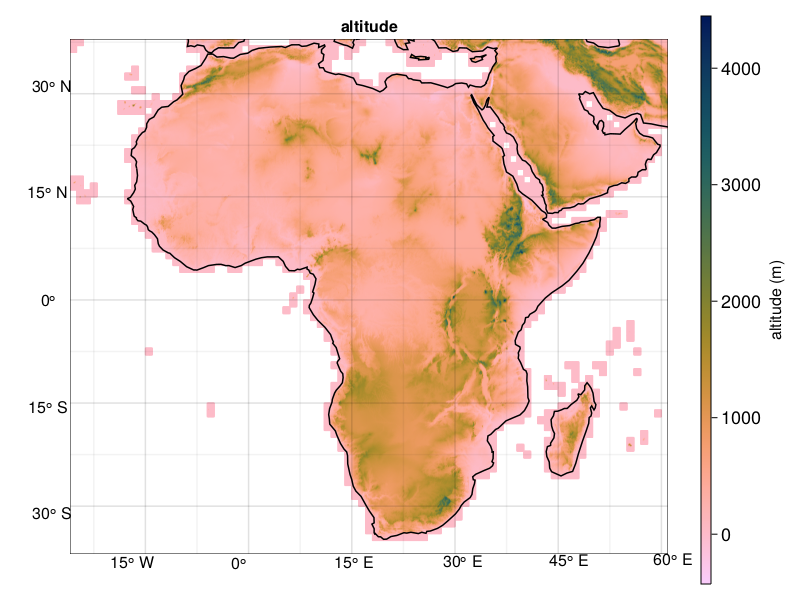

In [19]:
lon = collect(altitude_africa.lon)
lat = collect(altitude_africa.lat)

fig = Figure()
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = string("altitude")
)
map1 = CairoMakie.heatmap!(ga, lon, lat, altitude_africa.data[:,:,1], colormap = Reverse(:batlow))
cbar1 = Colorbar(fig[1,2], map1, label= "altitude (m)", ticklabelsize=18, labelpadding=5, width=10)
fig


Before running the mask we will estimate the altitude variability indicators $v_{1}$, $v_{2}$ and $v_{3}$ and plot the maps and the distributions of the data.

In [20]:
altitude_variability = altitude_mask_results_proc(altitude_africa; lon_axis_name = "lon", lat_axis_name = "lat", variable_name = "Variable", winsize = 5, showprog=true)

YAXArray with the following dimensions
Indicators          Axis with 3 elements: v1 v2 v3 
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
Total size: 21.51 MB


In [21]:
v1_thr_default = 50 
v2_thr_default = 50
v3_thr_default = 50

50

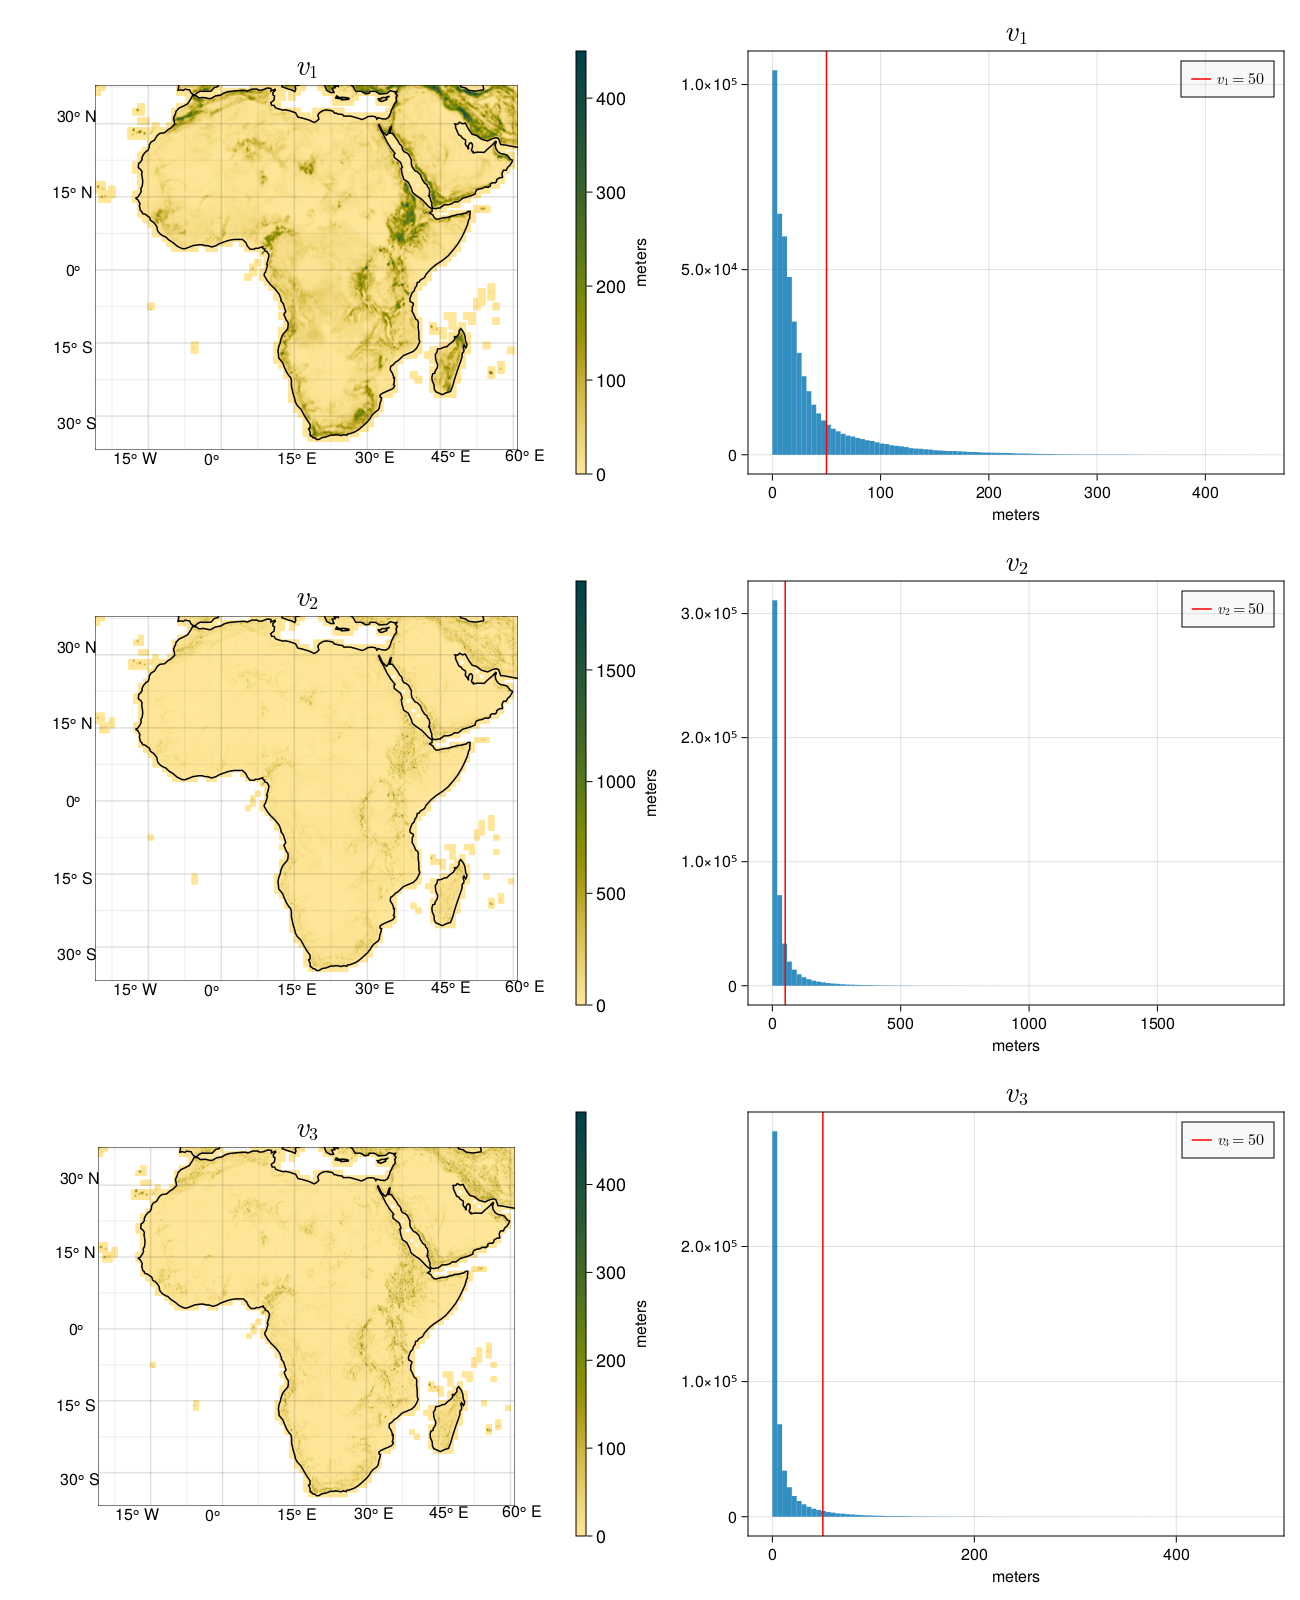

In [22]:
lon = collect(altitude_variability.lon)
lat = collect(altitude_variability.lat)

fig = Figure(resolution = (1300,1600))
# maps
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = L"v_{1}",
    titlesize = 30
)
map1 = CairoMakie.heatmap!(ga, lon, lat, altitude_variability.data[1,:,:], colormap = Reverse(:bamako))
cbar1 = Colorbar(fig[1,2], map1, label= "meters", ticklabelsize=18, labelpadding=5, width=10)

ga = GeoAxis(
    fig[2, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = L"$v_{2}$",
    titlesize = 30
)

map2 = CairoMakie.heatmap!(ga, lon, lat, altitude_variability.data[2,:,:], colormap = Reverse(:bamako))
cbar2 = Colorbar(fig[2,2], map2, label= "meters", ticklabelsize=18, labelpadding=5, width=10)

ga = GeoAxis(
    fig[3, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = L"$v_{3}$",
    titlesize = 30
)

map3 = CairoMakie.heatmap!(ga, lon, lat, altitude_variability.data[3,:,:], colormap = Reverse(:bamako))
cbar3 = Colorbar(fig[3,2], map3, label= "meters", ticklabelsize=18, labelpadding=5, width=10)


# data distribution
ax = Axis(fig[1, 3], title = L"v_{1}", titlesize = 30, xlabel = "meters")
hist!(filter(!isnan, vec(altitude_variability.data[1,:,:])); bins = 100)
vlines!(v1_thr_default, color = :red, label = L"v_{1} = %$(v1_thr_default)")
axislegend(; position = :rt, bgcolor = (:grey90, 0.25))

ax = Axis(fig[2, 3], title = L"v_{2}", titlesize = 30, xlabel = "meters")
hist!(filter(!isnan, vec(altitude_variability.data[2,:,:])); bins = 100)
vlines!(v2_thr_default, color = :red, label = L"v_{2} = %$(v2_thr_default)")
axislegend(; position = :rt, bgcolor = (:grey90, 0.25))

ax = Axis(fig[3,3], title = L"v_{3}", titlesize = 30, xlabel = "meters")
hist!(filter(!isnan, vec(altitude_variability.data[3,:,:])); bins = 100)
vlines!(v3_thr_default; color = :red, label = L"v_{3} = %$(v3_thr_default)")

axislegend(; position = :rt, bgcolor = (:grey90, 0.25))

fig

!! We will use the ```altitude_masking_proc``` function to mask the values where altitude variability can have an impact on the results.

In [29]:
metrics_for_transitions_alt_mask = altitude_masking_proc(results_space4time_africa_metrics_transitions_filtered, altitude_africa; lon_axis_name = "lon", lat_axis_name = "lat", variable_name = "Variable", time_axis_name = "time", winsize = 5, v1_thr = v1_thr_default, v2_thr = v2_thr_default, v3_thr = v3_thr_default, showprog = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:26:12


YAXArray Dataset
Dimensions: 
   transitions         Axis with 136 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Barren to Water_Bodies Urban_and_Built-up_Lands to Water_Bodies 
   Differences         Axis with 3 elements: delta delta_error coocurence 
   lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
   Masked_pixel        Axis with 1 elements: value 
   lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
   time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
Variables: cube_masked masked_pixels 

We can plot which pixels where masked using the ```masked_pixels``` variable.

In [30]:
pixels_masked = metrics_for_transitions_alt_mask.masked_pixels

YAXArray with the following dimensions
Masked_pixel        Axis with 1 elements: value 
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
Total size: 7.17 MB


In [31]:
all(iszero, pixels_masked.data[1,:,:])

false

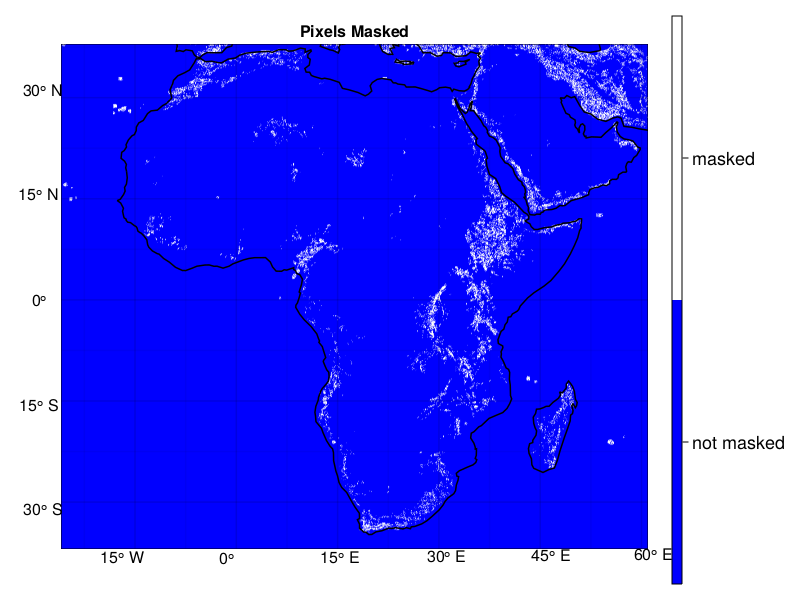

In [32]:
lon = collect(pixels_masked.lon)
lat = collect(pixels_masked.lat)

fig = Figure()

ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = string("Pixels Masked")
)
colors = [:blue,:white]
nc = length(colors)
nδ = 1/nc
map1 = CairoMakie.heatmap!(ga, lon, lat, pixels_masked.data[1,:,:], colormap = cgrad(colors, categorical=true)) 
cbar1 = Colorbar(fig[1,2], map1, ticklabelsize=18, labelpadding=5, width=10)
cbar1.ticks = (range(0.5+nδ/2, 0.5-nδ/2, nc), ["masked", "not masked"])
fig

### Removing transitions without interest

For the analysis, we will remove the following classes as they are not of interest to us.
```
"Permanent_Snow_and_Ice", 
"Urban_and_Built-up_Lands",
"Water_Bodies"
    ```

In [35]:
transitions_names = getAxis("transitions", metrics_for_transitions_collapsed_2).values


to_filter = ["Permanent_Snow_and_Ice", "Urban_and_Built-up_Lands", "Water_Bodies"]

for i in eachindex(to_filter)
    coincidence = findall(!isempty, findall.(to_filter[i], transitions_names))
    deleteat!(transitions_names, coincidence)
end

transitions_names

91-element Vector{String}:
 "Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests"
 "Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests"
 "Evergreen_Needleleaf_Forests to Deciduous_Broadleaf_Forests"
 "Evergreen_Needleleaf_Forests to Mixed_Forests"
 "Evergreen_Needleleaf_Forests to Closed_Shrublands"
 "Evergreen_Needleleaf_Forests to Open_Shrublands"
 "Evergreen_Needleleaf_Forests to Woody_Savannas"
 "Evergreen_Needleleaf_Forests to Savannas"
 "Evergreen_Needleleaf_Forests to Grasslands"
 "Evergreen_Needleleaf_Forests to Permanent_Wetlands"
 "Evergreen_Needleleaf_Forests to Croplands"
 "Evergreen_Needleleaf_Forests to Cropland_Natural_Vegetation_Mosaics"
 "Evergreen_Needleleaf_Forests to Barren"
 ⋮
 "Savannas to Cropland_Natural_Vegetation_Mosaics"
 "Savannas to Barren"
 "Grasslands to Permanent_Wetlands"
 "Grasslands to Croplands"
 "Grasslands to Cropland_Natural_Vegetation_Mosaics"
 "Grasslands to Barren"
 "Permanent_Wetlands to Croplands"
 "Permanent_Wetlands to Cro

In [36]:
metrics_for_transitions_2 = metrics_for_transitions_2[transitions = transitions_names]

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
transitions         Axis with 91 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Croplands to Barren Cropland_Natural_Vegetation_Mosaics to Barren 
Differences         Axis with 3 elements: delta delta_error coocurence 
Total size: 221.69 GB


We will plot all the co-occurence results for the transitions where we have data. ```time_metric = 1``` means the mean of the time series while ```time_metric = 2``` means standard deviation of the time series

In [ ]:
#=
time_metric = 1


time_collapsed_names = getAxis("time_collapsed", metrics_for_transitions_collapsed_2).values
transitions_names = getAxis("transitions", metrics_for_transitions_collapsed_2).values
lon = getAxis("lon", metrics_for_transitions_collapsed_2).values
lat = getAxis("lat", metrics_for_transitions_collapsed_2).values
time_cube = getAxis("time", results_space4time_africa.metrics_for_transitions).values


for i in eachindex(transitions_names[1])
   if any(!isnan, metrics_for_transitions_collapsed_2.data[:,:,time_metric,i,3])
        fig = Figure()
        ga = GeoAxis(
        fig[1, 1],
        source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
        coastlines = true,
        lonlims = (minimum(lon), maximum(lon)),
        latlims = (minimum(lat), maximum(lat)),
        title = transitions_names[i] * string("\n", first(time_cube), "--", last(time_cube), " ", time_collapsed_names[time_metric])
        )
        map1 = CairoMakie.heatmap!(ga, lon, lat, metrics_for_transitions_collapsed_2.data[:,:,time_metric,i,3], colormap = Reverse(:roma), colorrange = (0, 1))
        cbar1 = Colorbar(fig[1,2], map1, label= "coocurrence", ticklabelsize=18, labelpadding=5, width=10)
        display(fig)
    end
    
end
=#

We'll plot the data for the transitions ```Evergreen Broadleaf forest to Croplands```


In [39]:
transitions_names = getAxis("transitions", metrics_for_transitions_2).values
transition_index = first(findall(x -> occursin("Evergreen_Broadleaf_Forests to Croplands", x), transitions_names))

23

In this case ```"Evergreen_Broadleaf_Forests to Croplands``` correspond to transitions index: 23.


Now, let's plot the results!


In [40]:
metrics_for_transitions_2

YAXArray with the following dimensions
time                Axis with 116 Elements from 2002-05-01T00:00:00 to 2011-12-01T00:00:00
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
transitions         Axis with 91 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Croplands to Barren Cropland_Natural_Vegetation_Mosaics to Barren 
Differences         Axis with 3 elements: delta delta_error coocurence 
Total size: 221.69 GB


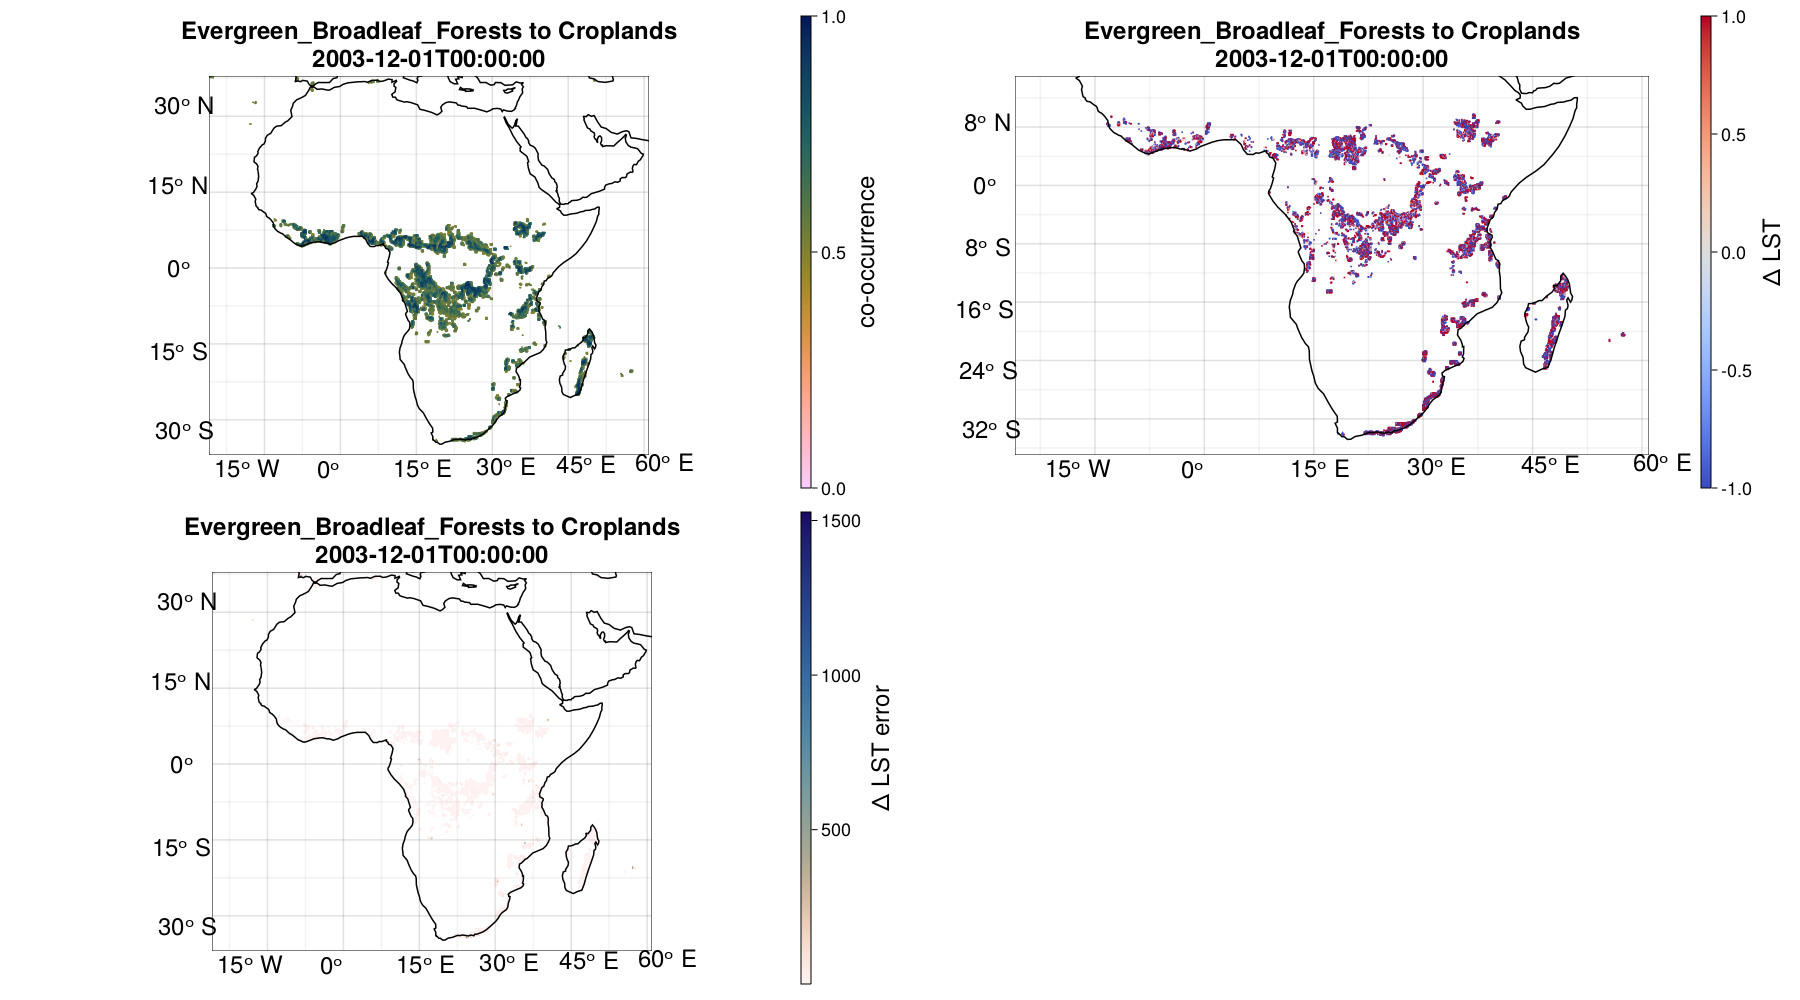

In [42]:
time_index = 20

transitions_names = getAxis("transitions", metrics_for_transitions_2).values
lon = getAxis("lon", metrics_for_transitions_2).values
lat = getAxis("lat", metrics_for_transitions_2).values
time_cube = getAxis("time", metrics_for_transitions_2).values


fig = Figure(resolution = (1800,1000), fontsize = 24)
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = transitions_names[transition_index] * string("\n", time_cube[time_index])
)
map1 = CairoMakie.heatmap!(ga, lon, lat, metrics_for_transitions_2.data[time_index,:,:,transition_index,3], colormap = Reverse(:batlow), colorrange = (0,1))

cbar1 = Colorbar(fig[1,2], map1, label= "co-occurrence", ticklabelsize=18, labelpadding=5, width=10)

ga = GeoAxis(
    fig[1, 3],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), 15), #maximum(lat)
    title = transitions_names[transition_index] * string("\n", time_cube[time_index])
)

map2 = CairoMakie.heatmap!(ga, lon, lat, metrics_for_transitions_collapsed_2.data[time_index,:,:,transition_index,1], colormap = :coolwarm, colorrange = (-1, 1))
cbar2 = Colorbar(fig[1,4], map2, label= "Δ LST", ticklabelsize=18, labelpadding=5, width=10)

ga = GeoAxis(
    fig[2, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lon), maximum(lon)),
    latlims = (minimum(lat), maximum(lat)),
    title = transitions_names[transition_index] * string("\n", time_cube[time_index])
)

map3 = CairoMakie.heatmap!(ga, lon, lat, metrics_for_transitions_collapsed_2.data[time_index,:,:,transition_index,2], colormap = Reverse(:lapaz))
cbar3 = Colorbar(fig[2,2], map3, label= "Δ LST error", ticklabelsize=18, labelpadding=5, width=10)

fig

In [54]:
save_path = "/Net/Groups/BGI/scratch/dpabon/tmp_results_nfdi/"

time_cube = getAxis("time", metrics_for_transitions_2).values

for i in eachindex(time_cube)
    time_index = i
    transitions_names = getAxis("transitions", metrics_for_transitions_2).values
    lon = getAxis("lon", metrics_for_transitions_2).values
    lat = getAxis("lat", metrics_for_transitions_2).values


    fig = Figure(resolution = (1800,1000), fontsize = 24)
    ga = GeoAxis(
        fig[1, 1],
        source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
        coastlines = true,
        lonlims = (minimum(lon), maximum(lon)),
        latlims = (minimum(lat), 15), #maximum(lat)
        title = transitions_names[transition_index] * string("\n", time_cube[time_index])
    )

    map2 = CairoMakie.heatmap!(ga, lon, lat, metrics_for_transitions_2.data[time_index,:,:,transition_index,1], colormap = :diverging_bwr_55_98_c37_n256,  highclip = last(ColorSchemes.diverging_bwr_55_98_c37_n256), lowclip = first(ColorSchemes.diverging_bwr_55_98_c37_n256), colorrange = (-1, 1))
    cbar2 = Colorbar(fig[1,2], map2, label= "Δ LST", ticklabelsize=18, labelpadding=5, width=10)
    cbar2.ticks = (range(1.0, -1.0, 5), [">= 1.0", "0.5", "0.0", "-0.5", "<= -1.0"])
    fig
    save(save_path * "space4time_africa_$time_index.png", fig, px_per_unit = 2)
end


### Outliers physical constrain

We will mask values with a delta higher than 10 and lower than -10 as we expect no higher variations of LST when there is a transition from EBF to CROP.

In [ ]:

get(ColorSchemes.diverging_bwr_55_98_c37_n256, -1)

### Outliers removal

As we can see there are many outliers in the results then we will remove the outliers. First we will plot the distribution of the data for the transition ```"Evergreen_Broadleaf_Forests to Croplands```


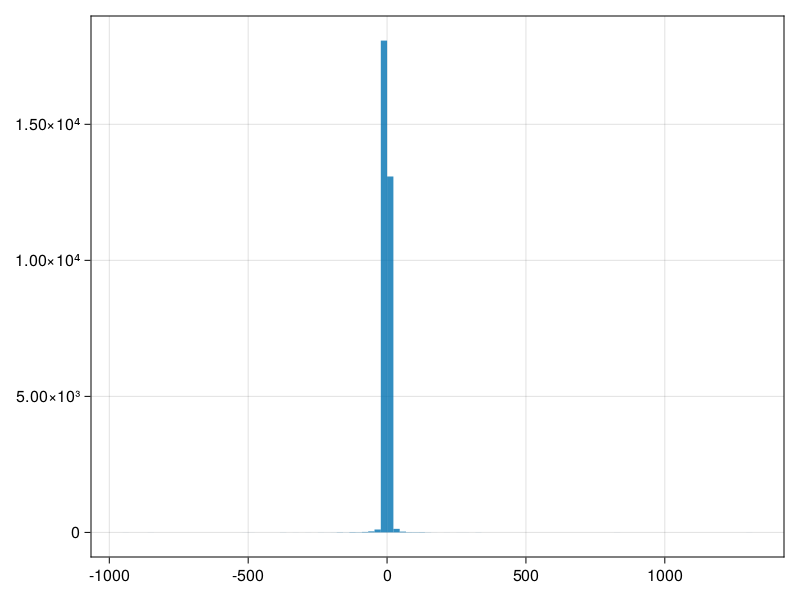

In [83]:
hist(filter(!isnan,vec(metrics_for_transitions_collapsed_2[:,:,1,transition_index,1])), bins = 100)

Then we will estimate the quantiles 0.2, and 0.8 per transitions and replace those values with NaNs.


In [84]:
# Defining masking function

function masking_outliers(cube_out, cube_in; quant1, quant2) 
    cube_out .= cube_in
    if any(!isnan, cube_out)
        quant = quantile(filter(!isnan,vec(cube_in)), (quant1, quant2))
        replace!(x -> x < quant[1] || x > quant[2] ? NaN : x, cube_out)
    end
end


# in this case we will use as input dimensions all the dimension except the transitions, and Differences as we want to compute the outliers for each one of the classes on these categories

indims = InDims("lon", "lat")
outdims = OutDims("lon", "lat")
new_results_metrics_transitions = mapCube(masking_outliers, metrics_for_transitions_collapsed_2, indims = indims, outdims = outdims, max_cache = 1e9, showprog=true; quant1 = 0.2, quant2 = 0.8)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


YAXArray with the following dimensions
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
time_collapsed      Axis with 2 elements: mean sd 
transitions         Axis with 91 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Croplands to Barren Cropland_Natural_Vegetation_Mosaics to Barren 
Differences         Axis with 3 elements: delta delta_error coocurence 
Total size: 3.82 GB


Now we can save the results of delta in a new zarr cube.

In [85]:
savecube(new_results_metrics_transitions, "/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_summary_stats_slurm_filtered.zarr/", overwrite = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


YAXArray with the following dimensions
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
time_collapsed      Axis with 2 elements: mean sd 
transitions         Axis with 91 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Croplands to Barren Cropland_Natural_Vegetation_Mosaics to Barren 
Differences         Axis with 3 elements: delta delta_error coocurence 
Total size: 3.82 GB


In [86]:
new_results_metrics_transitions = open_dataset("/Net/Groups/BGI/scratch/dpabon/results_space4time_africa_summary_stats_slurm_filtered.zarr/")
new_results_metrics_transitions = Cube(new_results_metrics_transitions)

YAXArray with the following dimensions
lon                 Axis with 1044 Elements from -25.958333333333332 to 60.95833333333333
lat                 Axis with 900 Elements from 37.95833333333334 to -36.95833333333333
time_collapsed      Axis with 2 elements: mean sd 
transitions         Axis with 91 elements: Evergreen_Needleleaf_Forests to Evergreen_Broadleaf_Forests Evergreen_Needleleaf_Forests to Deciduous_Needleleaf_Forests .. Croplands to Barren Cropland_Natural_Vegetation_Mosaics to Barren 
Differences         Axis with 3 elements: delta delta_error coocurence 
name: layer
Total size: 3.82 GB


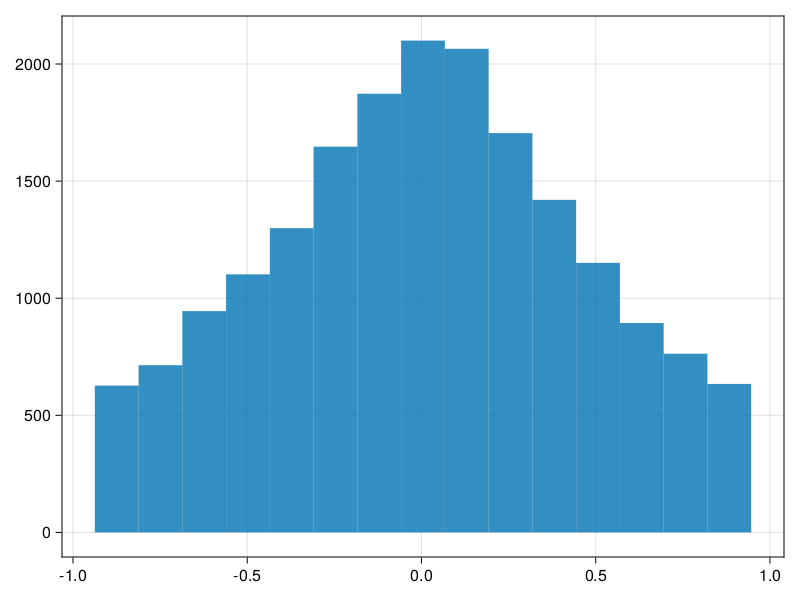

In [87]:
hist(filter(!isnan,vec(new_results_metrics_transitions.data[:,:,1,transition_index,1])))

Now let's plot again the results for Delta.

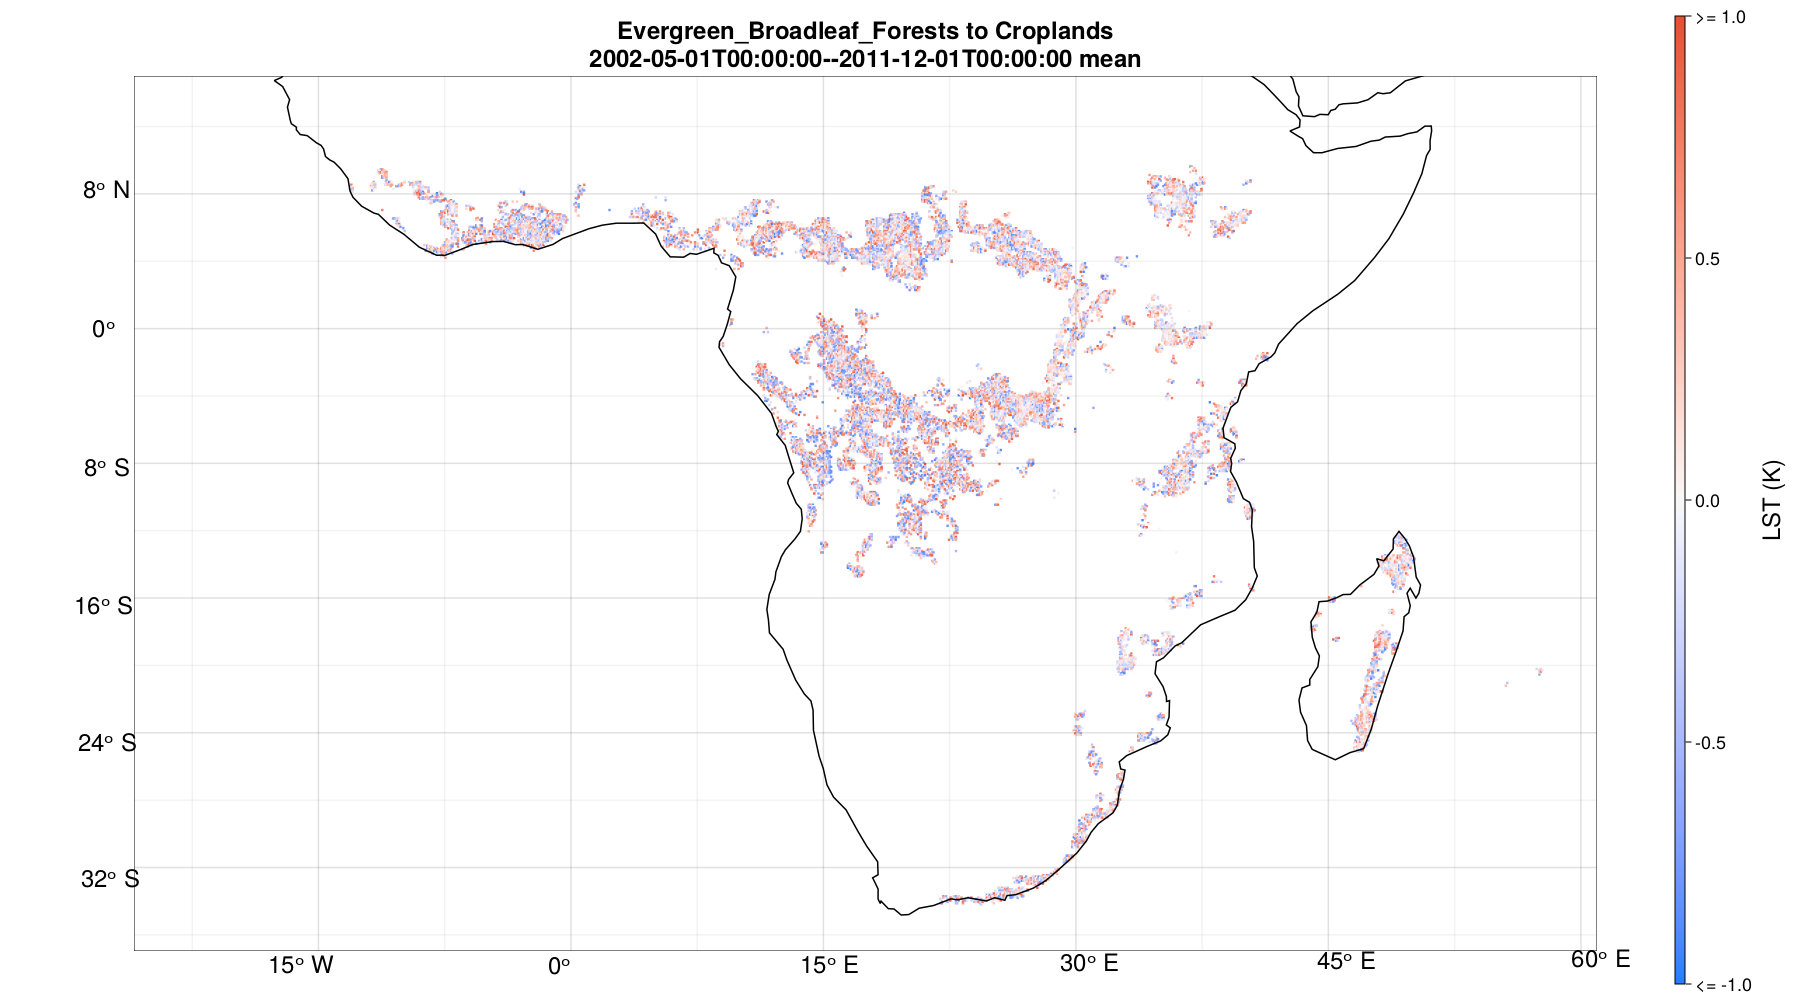

In [88]:
lon = getAxis("lon", lst_africa).values
lat = getAxis("lat", lst_africa).values

time_to_plot = 1

fig = Figure(resolution = (1800,1000), fontsize = 24)
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84", dest = "+proj=longlat",
    coastlines = true,
    lonlims = (minimum(lst_africa.lon), maximum(lst_africa.lon)),
    latlims = (minimum(lst_africa.lat), 15),
    title = transitions_names[transition_index] * string("\n", first(time_cube), "--", last(time_cube), " ", time_collapsed_names[time_metric])
)
map1 = CairoMakie.heatmap!(ga, lon, lat, new_results_metrics_transitions[:,:,1,transition_index,1], colormap = :diverging_bwr_55_98_c37_n256, colorrange = (-1, 1))
cbar1 = Colorbar(fig[1,2], map1, label= "LST (K)", ticklabelsize=18, labelpadding=5, width=10)
cbar1.ticks = (range(1.0, -1.0, 5), [">= 1.0", "0.5", "0.0", "-0.5", "<= -1.0"])

fig

In [ ]:
altitude = open_dataset("/Net/Groups/BGI/scratch/dpabon/")